# **Fine-tuning Vintern-1B-v2 on 5CD/Viet-Receipt-VQA**

In this notebook, we will fine-tune Vintern-1B by 5CD/Viet-Receipt-VQA an Vietnamese dataset, a new vision language model capable of various tasks, on document question answering for Vietnamese.

Reference: https://internvl.readthedocs.io/en/latest/internvl2.0/finetune.html

Check it more about us: [Fifth Civil Defender - 5CD - AI](https://huggingface.co/5CD-AI)

Let's start by installing the dependencies and loading the dataset.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q datasets flash_attn timm einops peft wandb deepspeed accelerate bitsandbytes decord tensorboardX gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 68.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 73.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 117.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
%cd /content/drive/MyDrive/ComputerVision/CK

/content/drive/MyDrive/ComputerVision/CK


In [4]:
!git clone https://github.com/5CD-AI/Vintern.git
%cd /content/drive/MyDrive/ComputerVision/CK/Vintern

Cloning into 'Vintern'...
remote: Enumerating objects: 2339, done.
remote: Total 2339 (delta 0), reused 0 (delta 0), pack-reused 2339 (from 1)
Receiving objects: 100% (2339/2339), 36.44 MiB | 10.04 MiB/s, done.
Resolving deltas: 100% (1340/1340), done.
Updating files: 100% (650/650), done.
/content/drive/MyDrive/ComputerVision/CK/Vintern


In [5]:
import pandas as pd
import json
import os
from uuid import uuid4
from PIL import Image

# **Load dataset**

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tronggg/vitextvqa")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/vitextvqa


In [7]:
def read_json(path):
    with open(path, 'r') as f:
        data = json.load(f)
        images_list = data['annotations']
        return pd.DataFrame(images_list)

In [34]:
df_train = read_json("/kaggle/input/vitextvqa/ViTextVQA_json/ViTextVQA_train.json")
df_test = read_json("/kaggle/input/vitextvqa/ViTextVQA_json/ViTextVQA_test.json")
df_val = read_json("/kaggle/input/vitextvqa/ViTextVQA_json/ViTextVQA_dev.json")
df_train['id'] = df_train['image_id']
df_test['id'] = df_test['image_id']
df_val['id'] = df_val['image_id']
df_train

,id,image_id,question,answers
0,0,0,quán ăn này bán những món gì ?,"[mì quảng , bún bò huế]"
1,0,0,quán ăn này bán mì gì ?,[mì quảng]
2,0,0,quán ăn gì bán bún gì ?,[bún bò huế]
3,0,0,quán ăn này địa chỉ ở đâu ?,"[13a trần quốc thảo , phường 7 , quận 3]"
4,1,1,tiệm trong ảnh là tiệm gì ?,[sửa xe]
...,...,...,...,...
35154,16760,16760,cuốn sách này có tên là gì ?,[phố cổ hà nội kí họa và hồi ức]
35155,16760,16760,dòng chữ ở góc trên bên phải cuốn sách này là ...,[nhiều tác giả]
35156,16761,16761,bệnh viện này có tên là gì ?,[bệnh nhiệt đới trung ương]
35157,16761,16761,bệnh viện này thuộc bộ nào ?,[y tế]


In [35]:
def format_image(root_dir, df_1):
    df_1["image_id"] = df_1['image_id'].apply(lambda x: os.path.join(root_dir, str(x) + ".jpg"))
    df_1 = df_1.dropna(subset=['question','answers']).copy()
    df_1['question'] = df_1['question'].astype(str)
    df_1['answers'] = df_1['answers'].astype(str)
    df_1.reset_index(drop=True, inplace=True)
    return df_1

In [36]:
root_dir = '/kaggle/input/vitextvqa/ViTextVQA_images/st_images'
df_train = format_image(root_dir, df_train)
df_test = format_image(root_dir, df_test)
df_val = format_image(root_dir, df_val)
df_train

,id,image_id,question,answers
0,0,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,quán ăn này bán những món gì ?,"['mì quảng , bún bò huế']"
1,0,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,quán ăn này bán mì gì ?,['mì quảng']
2,0,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,quán ăn gì bán bún gì ?,['bún bò huế']
3,0,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,quán ăn này địa chỉ ở đâu ?,"['13a trần quốc thảo , phường 7 , quận 3']"
4,1,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,tiệm trong ảnh là tiệm gì ?,['sửa xe']
...,...,...,...,...
35154,16760,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,cuốn sách này có tên là gì ?,['phố cổ hà nội kí họa và hồi ức']
35155,16760,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,dòng chữ ở góc trên bên phải cuốn sách này là ...,['nhiều tác giả']
35156,16761,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,bệnh viện này có tên là gì ?,['bệnh nhiệt đới trung ương']
35157,16761,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,bệnh viện này thuộc bộ nào ?,['y tế']


In [37]:
import pandas as pd

# Hàm xử lý câu trả lời: chuyển danh sách thành chuỗi
def format_answer(answer):
    if isinstance(answer, list):
        return ", ".join(answer)
    return str(answer)

# Hàm tạo conversations từ một nhóm dữ liệu
def create_conversations(group):
    conversations = []
    for _, row in group.iterrows():
        conversations.append({
            "from": "human",
            "value": row['question']
        })
        conversations.append({
            "from": "gpt",
            "value": format_answer(row['answers'])
        })
    return conversations

# Tạo mapping từ image_id đến id (chọn id đầu tiên cho mỗi image_id)
id_mapping = df_train.groupby('image_id')['id'].first().to_dict()

# Nhóm theo image_id và tạo conversations
grouped = df_train.groupby('image_id').apply(create_conversations, include_groups=False).reset_index(name='conversations')

# Thêm cột id từ mapping
grouped['id'] = grouped['image_id'].map(id_mapping)

# Tạo DataFrame kết quả với ba cột: id, image, conversations
df_train = grouped[['id', 'image_id', 'conversations']].rename(columns={'image_id': 'image'})

df_train

,id,image,conversations
0,0,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,"[{'from': 'human', 'value': 'quán ăn này bán n..."
1,1,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,"[{'from': 'human', 'value': 'tiệm trong ảnh là..."
2,1000,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,"[{'from': 'human', 'value': 'người phụ nữ bán ..."
3,10000,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,"[{'from': 'human', 'value': 'cửa hàng ở giữa c..."
4,10002,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,"[{'from': 'human', 'value': 'phố ở chính giữa ..."
...,...,...,...
11728,9994,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,"[{'from': 'human', 'value': 'dòng chữ ở trên b..."
11729,9995,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,"[{'from': 'human', 'value': 'cửa hàng bên trái..."
11730,9997,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,"[{'from': 'human', 'value': 'nguồn của bức ảnh..."
11731,9998,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,"[{'from': 'human', 'value': 'cửa hàng này có t..."


In [38]:
df_train['image'][3]

'/kaggle/input/vitextvqa/ViTextVQA_images/st_images/10000.jpg'

In [39]:
df_train = df_train.iloc[0:1000]
df_train

,id,image,conversations
0,0,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,"[{'from': 'human', 'value': 'quán ăn này bán n..."
1,1,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,"[{'from': 'human', 'value': 'tiệm trong ảnh là..."
2,1000,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,"[{'from': 'human', 'value': 'người phụ nữ bán ..."
3,10000,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,"[{'from': 'human', 'value': 'cửa hàng ở giữa c..."
4,10002,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,"[{'from': 'human', 'value': 'phố ở chính giữa ..."
...,...,...,...
995,11264,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,"[{'from': 'human', 'value': 'bức ảnh này có nộ..."
996,11265,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,"[{'from': 'human', 'value': 'địa chỉ quán ăn n..."
997,11266,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,"[{'from': 'human', 'value': 'chợ hoa tết truyề..."
998,11267,/kaggle/input/vitextvqa/ViTextVQA_images/st_im...,"[{'from': 'human', 'value': 'người phát ngôn n..."


In [40]:
import pandas as pd
from PIL import Image
from datasets import Dataset
from tqdm import tqdm
import gc

def safe_convert_to_rgb(image_path, max_size=(512, 512)):
    try:
        img = Image.open(image_path)
        if img.mode == 'P' and 'transparency' in img.info:
            img = img.convert('RGBA')
        img = img.convert('RGB')
        img.thumbnail(max_size)
        return img
    except Exception as e:
        print(f"Lỗi khi mở hình ảnh {image_path}: {e}")
        return None

# Giả định df_train là DataFrame chứa dữ liệu đầu vào
batch_size = 1000
examples = []

# Lặp qua DataFrame theo batch
for start in tqdm(range(0, len(df_train), batch_size), desc="Xử lý batch"):
    end = min(start + batch_size, len(df_train))
    batch_df = df_train.iloc[start:end]

    for _, row in batch_df.iterrows():
        image_path = row['image']  # Lấy đường dẫn hình ảnh từ cột 'image_id'
        image = safe_convert_to_rgb(image_path, max_size=(512, 512))
        if image is None:
            continue

        # Tạo dictionary cho mỗi mẫu
        example = {
            'id': row['id'],
            'image': image,
            'conversations': row['conversations'],
        }
        examples.append(example)

    # Giải phóng bộ nhớ sau mỗi batch
    gc.collect()

# Chuyển danh sách thành Dataset
dataset = Dataset.from_list(examples)

print("Chuyển đổi hoàn tất. Dataset đã sẵn sàng để sử dụng.")

Xử lý batch: 100%|██████████| 1/1 [00:36<00:00, 36.52s/it]


Chuyển đổi hoàn tất. Dataset đã sẵn sàng để sử dụng.


In [41]:
dataset

Dataset({
    features: ['id', 'image', 'conversations'],
    num_rows: 1000
})

In [42]:
dataset[0]

{'id': 0,
 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x287>,
 'conversations': [{'from': 'human',
   'value': 'quán ăn này bán những món gì ?'},
  {'from': 'gpt', 'value': "['mì quảng , bún bò huế']"},
  {'from': 'human', 'value': 'quán ăn này bán mì gì ?'},
  {'from': 'gpt', 'value': "['mì quảng']"},
  {'from': 'human', 'value': 'quán ăn gì bán bún gì ?'},
  {'from': 'gpt', 'value': "['bún bò huế']"},
  {'from': 'human', 'value': 'quán ăn này địa chỉ ở đâu ?'},
  {'from': 'gpt', 'value': "['13a trần quốc thảo , phường 7 , quận 3']"}]}

# **Prepare model**

## Download model

Before starting the second fine-tuning, download the pre-trained model is provided.

In [43]:
!mkdir -p pretrained
%cd pretrained/
# Download 5CD-AI/Vintern-1B-v2 ---- Vision Part:InternViT‑300M‑448px + Language Part: Qwen2‑0.5B‑Instruct
!huggingface-cli download --resume-download --local-dir-use-symlinks False 5CD-AI/Vintern-1B-v2 --local-dir Vintern-1B-v2

/content/drive/MyDrive/ComputerVision/CK/Vintern/pretrained
/usr/local/lib/python3.11/dist-packages/huggingface_hub/commands/download.py:139: FutureWarning: Ignoring --local-dir-use-symlinks. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Fetching 22 files: 100% 22/22 [00:00<00:00, 119.17it/s]
/content/drive/MyDrive/ComputerVision/CK/Vintern/pretrained/Vintern-1B-v2


## Test single image

Let's do inference with our dataset first to see how the model performs already with our dataset before fine-tuning. After testing you should clear the gpu (restart session) for next steps.

In [44]:
#### Do not use flash attention if your device not support

# import json
# with open('pretrained/InternVL2-1B/config.json', 'r') as f:
#     config = json.load(f)
# config["vision_config"]["use_flash_attn"] = False
# with open('pretrained/InternVL2-1B/config.json', 'w') as f:
#     json.dump(config, f)

In [45]:
import os
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform

def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images

def load_image(image_file, input_size=448, max_num=12):
    #check image_file is a path or image
    if isinstance(image_file, str):
        image = Image.open(image_file).convert('RGB')
    else:
        image = image_file
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values

In [46]:
## load pretrained model
model_name = "/content/drive/MyDrive/ComputerVision/CK/Vintern/pretrained/Vintern-1B-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, use_fast=False)
model = AutoModel.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    trust_remote_code=True
).eval().cuda()

In [47]:
# ### Test samples
# for i in range(3):
#     image = dataset[i]['image']

#     plt.figure(figsize=(5,5))
#     plt.imshow(image)
#     plt.show()

#     pixel_values = load_image(image, max_num=12).to(torch.bfloat16).cuda()
#     generation_config = dict(max_new_tokens= 1024, do_sample=False, num_beams = 3, repetition_penalty=2.0)

#     question = '<image>\nTrích xuất thông tin hoá đơn trong ảnh.'

#     response = model.chat(tokenizer, pixel_values, question, generation_config)
#     print(f'User: {question}\nAssistant: {response}')
#     print("="*30)

In [48]:
torch.cuda.empty_cache()

# **Prepare Your Customized Training Data**

In [49]:
%cd /content/drive/MyDrive/ComputerVision/CK/Vintern

/content/drive/MyDrive/ComputerVision/CK/Vintern


## Single-Image Data
First you need to create a dataset json file to describe each item of your dataset

For single-image data, we use a **JSONL** file to store the data. Each entry is a dictionary organized in the following format. Note that each entry for single-image data must contain an image field, which is a string.

The path in the image field is relative to the root field. Concatenating the root field and the image field gives the complete path to the image. It is recommended to include width and height information for each data sample for future use.
```
{
  "id": 0,
  "image": "path/to/image.jpg",
  "width": 111,
  "height": 222,
  "conversations": [
    {"from": "human", "value": "<image>\nuser input"},
    {"from": "gpt", "value": "assistant output"},
    {"from": "human", "value": "user input"},
    {"from": "gpt", "value": "assistant output"}
  ]
}
```

Save image to image folder to get image_path to follow format of dataset

In [50]:
import os
from tqdm import tqdm
FOLDER_IMAGES = "/content/drive/MyDrive/ComputerVision/CK/ViTextVQAResized"
os.makedirs(FOLDER_IMAGES, exist_ok=True)

In [51]:

### Save image dataset
for i in tqdm(range(len(dataset))):
    image = dataset[i]['image']
    id = dataset[i]['id']

    #resize 448x448
    image = image.resize((448, 448)) # Just for saving vram
    image.save(f"{FOLDER_IMAGES}/{id}.jpg")

100%|██████████| 1000/1000 [00:26<00:00, 37.20it/s]


Format each item data follow format above

In [52]:
import json

all_data = []

for item in tqdm(dataset):
    # Just 500 items for example
    if len(all_data) >= 500:
        break
    id = item['id']
    image = f"{FOLDER_IMAGES}/{item['id']}.jpg"
    width = item['image'].width
    height = item['image'].height
    conversations = item['conversations']
    data = {
        "id": id,
        "image": image,
        "width": width,
        "height": height,
        "conversations": conversations
    }
    all_data.append(data)

print(len(all_data))
print(all_data[0:5])

 50%|█████     | 500/1000 [00:03<00:03, 129.97it/s]

500
[{'id': 0, 'image': '/content/drive/MyDrive/ComputerVision/CK/ViTextVQAResized/0.jpg', 'width': 512, 'height': 287, 'conversations': [{'from': 'human', 'value': 'quán ăn này bán những món gì ?'}, {'from': 'gpt', 'value': "['mì quảng , bún bò huế']"}, {'from': 'human', 'value': 'quán ăn này bán mì gì ?'}, {'from': 'gpt', 'value': "['mì quảng']"}, {'from': 'human', 'value': 'quán ăn gì bán bún gì ?'}, {'from': 'gpt', 'value': "['bún bò huế']"}, {'from': 'human', 'value': 'quán ăn này địa chỉ ở đâu ?'}, {'from': 'gpt', 'value': "['13a trần quốc thảo , phường 7 , quận 3']"}]}, {'id': 1, 'image': '/content/drive/MyDrive/ComputerVision/CK/ViTextVQAResized/1.jpg', 'width': 512, 'height': 384, 'conversations': [{'from': 'human', 'value': 'tiệm trong ảnh là tiệm gì ?'}, {'from': 'gpt', 'value': "['sửa xe']"}, {'from': 'human', 'value': 'tiệm sửa xe này sửa những xe gì ?'}, {'from': 'gpt', 'value': "['honda , tay ga']"}, {'from': 'human', 'value': 'tiệm sửa xe này tên gì ?'}, {'from': 'gpt',

In [53]:
### Write JSONL line
with open('/content/drive/MyDrive/ComputerVision/CK/Vintern/internvl_chat/shell/data/ViTextVQA.jsonl', 'w', encoding='utf-8') as f:
    for data in tqdm(all_data):
        f.write(json.dumps(data, ensure_ascii=False) + '\n')

100%|██████████| 500/500 [00:00<00:00, 46911.95it/s]


## Create meta file to manage the meta information of all datasets

After downloading the pre-trained model, prepare your customized SFT (Supervised Fine-Tuning) data. Create a JSON file in `internvl_chat/shell/data/` similar to [this example](https://github.com/OpenGVLab/InternVL/blob/main/internvl_chat/shell/data/internvl_1_2_finetune.json)

The format for the JSON file should be:

```
{
  "your-custom-dataset-1": {
    "root": "path/to/the/image/",
    "annotation": "path/to/the/jsonl/annotation",
    "data_augment": false,
    "repeat_time": 1,
    "length": "number of your data"
  },
  ...
}```



In [54]:
metadata_datasets = {
  "vi-text-vqa": {
    "root": "/content/drive/MyDrive/ComputerVision/CK/ViTextVQAResized",
    "annotation": "/content/drive/MyDrive/ComputerVision/CK/Vintern/internvl_chat/shell/data/ViTextVQA.jsonl",
    "data_augment": False,
    "repeat_time": 1,
    "length": 500
  }
}

with open('/content/drive/MyDrive/ComputerVision/CK/Vintern/internvl_chat/shell/data/custom_fintune_datasets.json', 'w', encoding='utf-8') as f:
    json.dump(metadata_datasets, f, ensure_ascii=False, indent=4)


# Training

## LoRA fine-tuning

Fine-tune the pre-trained models using either the script for training the [full LLM](https://internvl.readthedocs.io/en/latest/internvl2.0/finetune.html#:~:text=script%20for%20training%20the%20full%20LLM) or the script for training the [LoRA adapter](https://github.com/OpenGVLab/InternVL/blob/main/internvl_chat/shell/internvl2.0/2nd_finetune/internvl2_1b_qwen2_0_5b_dynamic_res_2nd_finetune_lora.sh), depending on your available GPU resources.

Before fine-tuning, set the --meta_path to the path of the JSON file you created in the previous step. The default pre-trained model path in these shell scripts is ./pretrained/InternVL2-1B.

In the default settings, I have frozen the visual encoder. You can unfreeze it if needed. Generally, unfreezing the visual encoder will result in better performance.



Edit file `InternVL/internvl_chat/shell/internvl2.0/2nd_finetune/internvl2_1b_qwen2_0_5b_dynamic_res_2nd_finetune_lora.sh` for train LoRA LLM follow example below

In [55]:
train_bash_content = '''set -x

GPUS=${GPUS:-1}
BATCH_SIZE=${BATCH_SIZE:-1}
PER_DEVICE_BATCH_SIZE=${PER_DEVICE_BATCH_SIZE:-1}
GRADIENT_ACC=$((BATCH_SIZE / PER_DEVICE_BATCH_SIZE / GPUS))


export PYTHONPATH="${PYTHONPATH}:$(pwd)"
export MASTER_PORT=34229
export TF_CPP_MIN_LOG_LEVEL=3
export LAUNCHER=pytorch

OUTPUT_DIR='/content/drive/MyDrive/ComputerVision/CK/work_dirs/internvl_chat_v2_0/Vintern_1B_v2_finetune_lora_vi_text_vqa'

if [ ! -d "$OUTPUT_DIR" ]; then
  mkdir -p "$OUTPUT_DIR"
fi

# number of gpus: 2
# batch size per gpu: 4
# gradient accumulation steps: 2
# total batch size: 16
# epoch: 1
torchrun \
  --nnodes=1 \
  --node_rank=0 \
  --master_addr=127.0.0.1 \
  --nproc_per_node=${GPUS} \
  --master_port=${MASTER_PORT} \
  internvl/train/internvl_chat_finetune.py \
  --model_name_or_path "/content/drive/MyDrive/ComputerVision/CK/Vintern/pretrained/Vintern-1B-v2" \
  --conv_style "Hermes-2" \
  --output_dir ${OUTPUT_DIR} \
  --meta_path "/content/drive/MyDrive/ComputerVision/CK/Vintern/internvl_chat/shell/data/custom_fintune_datasets.json" \
  --overwrite_output_dir True \
  --force_image_size 448 \
  --max_dynamic_patch 6 \
  --down_sample_ratio 0.5 \
  --drop_path_rate 0.0 \
  --freeze_llm True \
  --freeze_mlp True \
  --freeze_backbone True \
  --use_llm_lora 16 \
  --vision_select_layer -1 \
  --dataloader_num_workers 4 \
  --bf16 True \
  --num_train_epochs 1 \
  --per_device_train_batch_size ${PER_DEVICE_BATCH_SIZE} \
  --gradient_accumulation_steps ${GRADIENT_ACC} \
  --save_strategy "steps" \
  --save_steps 500 \
  --save_total_limit 2 \
  --learning_rate 4e-5 \
  --weight_decay 0.01 \
  --warmup_ratio 0.03 \
  --lr_scheduler_type "cosine" \
  --logging_steps 10 \
  --max_seq_length 700 \
  --do_train True \
  --grad_checkpoint True \
  --group_by_length True \
  --dynamic_image_size True \
  --use_thumbnail True \
  --ps_version 'v2' \
  --deepspeed "zero_stage1_config.json" \
  --report_to "tensorboard" \
  2>&1 | tee -a "${OUTPUT_DIR}/training_log.txt"
'''

In [56]:
with open("/content/drive/MyDrive/ComputerVision/CK/Vintern/internvl_chat/shell/internvl2.0/2nd_finetune/internvl2_1b_qwen2_0_5b_dynamic_res_2nd_finetune_lora.sh", "w") as text_file:
    text_file.write(train_bash_content)

In [57]:
!ls -l /content/drive/MyDrive/ComputerVision/CK/ViTextVQAResized/
!chmod -R +r /content/drive/MyDrive/ComputerVision/CK/ViTextVQAResized/

total 37923
-rw------- 1 root root 38661 May  4 05:23 0.jpg
-rw------- 1 root root 33826 May  4 05:23 10000.jpg
-rw------- 1 root root 39422 May  4 05:23 10002.jpg
-rw------- 1 root root 36457 May  4 05:23 10003.jpg
-rw------- 1 root root 28906 May  4 05:23 10004.jpg
-rw------- 1 root root 31454 May  4 05:23 10005.jpg
-rw------- 1 root root 44532 May  4 05:23 10006.jpg
-rw------- 1 root root 44378 May  4 05:23 10007.jpg
-rw------- 1 root root 63115 May  4 05:23 10009.jpg
-rw------- 1 root root 34613 May  4 05:23 1000.jpg
-rw------- 1 root root 24566 May  4 05:23 10010.jpg
-rw------- 1 root root 45356 May  4 05:23 10011.jpg
-rw------- 1 root root 31193 May  4 05:23 10013.jpg
-rw------- 1 root root 51266 May  4 05:23 10014.jpg
-rw------- 1 root root 35189 May  4 05:23 10015.jpg
-rw------- 1 root root 42019 May  4 05:23 10016.jpg
-rw------- 1 root root 41554 May  4 05:23 10017.jpg
-rw------- 1 root root 38854 May  4 05:23 10018.jpg
-rw------- 1 root root 36041 May  4 05:23 10019.jpg
-rw--

Let's go training. It take about just 15 minutes with T4

In [59]:
%cd /content/drive/MyDrive/ComputerVision/CK/Vintern/internvl_chat
!sh shell/internvl2.0/2nd_finetune/internvl2_1b_qwen2_0_5b_dynamic_res_2nd_finetune_lora.sh

/content/drive/MyDrive/ComputerVision/CK/Vintern/internvl_chat
+ GPUS=1
+ BATCH_SIZE=1
+ PER_DEVICE_BATCH_SIZE=1
+ GRADIENT_ACC=1
+ pwd
+ export PYTHONPATH=/env/python:/content/drive/MyDrive/ComputerVision/CK/Vintern/internvl_chat
+ export MASTER_PORT=34229
+ export TF_CPP_MIN_LOG_LEVEL=3
+ export LAUNCHER=pytorch
+ OUTPUT_DIR=/content/drive/MyDrive/ComputerVision/CK/work_dirs/internvl_chat_v2_0/Vintern_1B_v2_finetune_lora_vi_text_vqa
+ [ ! -d /content/drive/MyDrive/ComputerVision/CK/work_dirs/internvl_chat_v2_0/Vintern_1B_v2_finetune_lora_vi_text_vqa ]
+ torchrun --nnodes=1 --node_rank=0 --master_addr=127.0.0.1 --nproc_per_node=1 --master_port=34229 internvl/train/internvl_chat_finetune.py --model_name_or_path /content/drive/MyDrive/ComputerVision/CK/Vintern/pretrained/Vintern-1B-v2 --conv_style Hermes-2 --output_dir /content/drive/MyDrive/ComputerVision/CK/work_dirs/internvl_chat_v2_0/Vintern_1B_v2_finetune_lora_vi_text_vqa --meta_path /content/drive/MyDrive/ComputerVision/CK/Vintern

In [60]:
import torch
torch.cuda.empty_cache()

## Merging LoRA Weights
After evaluating the fine-tuned model, you may want to merge the LoRA weights back into the original InternVL2 model. Follow these steps to accomplish this.

Use the provided script to merge the LoRA weights into the base model. The script takes two arguments: the input path of the fine-tuned model and the output path for the merged model.

`python tools/merge_lora.py <input_path> <output_path>`

In [61]:
merge_lora_content = '''import torch
import sys
sys.path.append("/content/drive/MyDrive/ComputerVision/CK/Vintern/internvl_chat")
from internvl.model.internvl_chat import InternVLChatModel
from transformers import AutoTokenizer
import argparse

argparse = argparse.ArgumentParser()
argparse.add_argument("input_path", type=str, help="Path to the input model")
argparse.add_argument("output_path", type=str, help="Path to the output model")
args = argparse.parse_args()

print("Loading model...")
model = InternVLChatModel.from_pretrained(
    args.input_path, low_cpu_mem_usage=True, torch_dtype=torch.bfloat16).eval()
print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(args.input_path, trust_remote_code=True)

if model.config.use_backbone_lora:
    model.vision_model.merge_and_unload()
    model.vision_model = model.vision_model.model
    model.config.use_backbone_lora = 0
if model.config.use_llm_lora:
    model.language_model.merge_and_unload()
    model.language_model = model.language_model.model
    model.config.use_llm_lora = 0

print("Saving model...")
model.save_pretrained(args.output_path)
print("Saving tokenizer...")
tokenizer.save_pretrained(args.output_path)
print("Done!")
'''

with open("/content/drive/MyDrive/ComputerVision/CK/Vintern/internvl_chat/tools/merge_lora.py", "w") as text_file:
    text_file.write(merge_lora_content)

In [63]:
### If could not import internvl edit add
### import sys
### sys.path.append("/content/Vintern/internvl_chat")

%cd /content/drive/MyDrive/ComputerVision/CK/Vintern/internvl_chat
!python tools/merge_lora.py /content/drive/MyDrive/ComputerVision/CK/work_dirs/internvl_chat_v2_0/Vintern_1B_v2_finetune_lora_vi_text_vqa \
                            /content/drive/MyDrive/ComputerVision/CK/work_dirs/internvl_chat_v2_0/Vintern_1B_v2_finetune_lora_vi_text_vqa_merge

/content/drive/MyDrive/ComputerVision/CK/Vintern/internvl_chat
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
2025-05-04 05:55:09.943453: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746338109.964531   11726 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746338109.970664   11726 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[2025-05-04 05:55:13,083] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator t

## Wrapping into AutoModel
After merging the LoRA weights, you can wrap the fine-tuned InternVL2 model into an AutoModel for easier inference or deployment.

First, copy all the Python scripts from the original InternVL2-2B directory to the new merged model directory:



In [64]:
!cp /content/drive/MyDrive/ComputerVision/CK/Vintern/pretrained/Vintern-1B-v2/*.py \
    /content/drive/MyDrive/ComputerVision/CK/work_dirs/internvl_chat_v2_0/Vintern_1B_v2_finetune_lora_vi_text_vqa_merge

Next, copy the config.json file from the original InternVL2-1B directory to the new merged model directory:

In [65]:
!cp /content/drive/MyDrive/ComputerVision/CK/Vintern/pretrained/Vintern-1B-v2/config.json \
    /content/drive/MyDrive/ComputerVision/CK/work_dirs/internvl_chat_v2_0/Vintern_1B_v2_finetune_lora_vi_text_vqa_merge

# Inference with fintuned model

After copying the necessary files, you can now load and use the fine-tuned InternVL2 model with AutoModel for inference

In [70]:
!pip install transformers==4.37.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 78.5 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling tokenizers-0.21.1:
      Successfully uninstalled tokenizers-0.21.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.3
    Uninstalling transformers-4.51.3:
      Successfully uninstalled transformers-4.51.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.4.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.37.2 which is incompatible.


In [66]:
import os
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform

def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images

def load_image(image_file, input_size=448, max_num=12):
    #check image_file is a path or image
    if isinstance(image_file, str):
        image = Image.open(image_file).convert('RGB')
    else:
        image = image_file
    image = image.resize((input_size, input_size))

    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values

In [71]:
## load pretrained model
model_name = "/content/drive/MyDrive/ComputerVision/CK/work_dirs/internvl_chat_v2_0/Vintern_1B_v2_finetune_lora_vi_text_vqa_merge"

model = AutoModel.from_pretrained(model_name,
                                  torch_dtype=torch.bfloat16,
                                  low_cpu_mem_usage=True,
                                  trust_remote_code=True).eval().cuda()
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, use_fast=False)


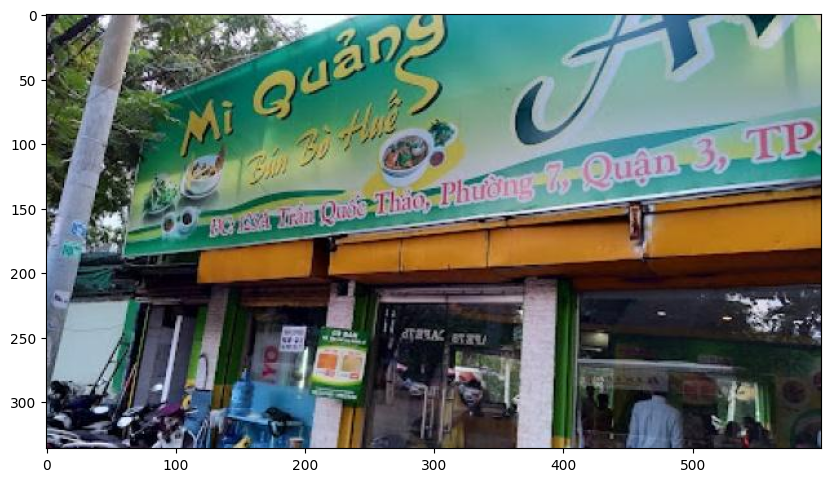

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


TypeError: Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151655, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2RotaryEmbedding()
  )
  (lm_head): Linear(in_features=896, out_features=151655, bias=False)
) got multiple values for keyword argument 'return_dict'

In [72]:
test_image = "/content/0.jpg"
plt.figure(figsize=(10,10))
plt.imshow(Image.open(test_image))
plt.show()
pixel_values = load_image(test_image, max_num=6).to(torch.bfloat16).cuda()
generation_config = dict(max_new_tokens= 512, do_sample=False, num_beams = 3, repetition_penalty=3.5)

question = '<image>\nMô tả hình ảnh một cách chi tiết trả về dạng markdown.'

response = model.chat(tokenizer, pixel_values, question, generation_config)
print(f'User: {question}\nAssistant: {response}')

This guide provided a step-by-step approach to enhancing the InternVL2 model on Viet-Receipt-VQA using LoRA fine-tuning. By following these instructions, you should be able to achieve improved performance in extraction tasks.  Viet-Receipt-VQA is just one example; you can replace it with other downstream datasets for fine-tuning. Happy fine-tuning!

DON'T WORRY ABOUT IT! WE HERE FOR YOU <3

You could find more Vietnamese datasets here.

Check it more about us: [Fifth Civil Defender - 5CD - AI](https://huggingface.co/5CD-AI)

